In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import progressbar
from multiarmbandit import MultiArmBandit
import utils

# Create a multi-arm-bandit.

In [2]:
arms = 10
environment = MultiArmBandit(arms)

# Helper functions.

In [3]:
def softmax(av, tau=1.12):
    n = len(av)
    probs = np.zeros(n)
    for i in range(n):
        softm = ( np.exp(av[i] / tau) / np.sum( np.exp(av[:] / tau) ) )
        probs[i] = softm
    return probs

def one_hot(length, index):
    encoding = np.zeros(length)
    encoding[index] = 1
    return encoding

# Create a Neural Network.

In [4]:
import torch as th

# Training parameters.
epochs = 5000
learning_rate = 1e-2

# Network parameters.
input_size = arms
hidden_size = 100
output_size = arms

model = th.nn.Sequential(
    th.nn.Linear(input_size, hidden_size),
    th.nn.ReLU(),
    th.nn.Linear(hidden_size, output_size),
    th.nn.ReLU(),
)

optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = th.nn.MSELoss(reduction="sum")

# Train Network.

100% (5000 of 5000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


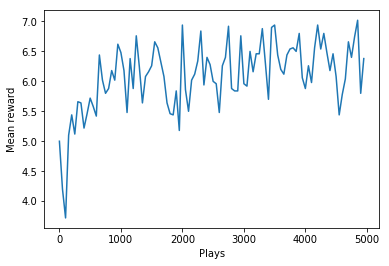

In [5]:
# Creating history of 50 rewards. Initialize all with 5.
running_mean_update_frequency = 50

reward_history = np.zeros(running_mean_update_frequency)
reward_history[:] = 5

plot_epochs = []
plot_running_means = []

bar = progressbar.ProgressBar(max_value = epochs)
for epoch in range(epochs):
    bar.update(epoch)
    
    # Get the current state and predict on it.
    current_state = environment.get_state()
    current_state = utils.one_hot(arms, current_state)
    current_state = th.Tensor(current_state)
    current_state = th.autograd.Variable(current_state)
    y_pred = model(current_state)
    
    # Perform the action and get the reward.
    av_softmax = utils.softmax(y_pred.data.numpy(),  tau=2.0)
    av_softmax /= av_softmax.sum()
    choice = np.random.choice(arms, p=av_softmax)
    current_reward = environment.pull_arm_and_get_reward(choice)
    
    # Get the reward and do a training-step.
    one_hot_reward = y_pred.data.numpy().copy()
    one_hot_reward[choice] = current_reward
    reward = th.autograd.Variable(th.Tensor(one_hot_reward))
    loss = loss_function(y_pred, reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Monitor running mean.
    if epoch % running_mean_update_frequency == 0:
        plot_epochs.append(epoch)
        running_mean = np.average(reward_history)
        plot_running_means.append(running_mean)
        reward_history[:] = 0
    reward_history[epoch % running_mean_update_frequency] = current_reward
    
bar.finish()

plt.xlabel("Plays")
plt.ylabel("Mean reward")
plt.plot(plot_epochs, plot_running_means)
plt.show()
plt.close()